In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from hf_olmo import OLMoTokenizerFast
import numpy as np
import os
from tqdm import tqdm, trange

model = 'gpt2-xl'
model = 'Llama-2-7b'
# model = 'Olmo'
model = 'pythia-6.9b'

dset_type = 'reasoning_tuned_-1'

def convert_layer(index):
    index = index.split('.')[-1]
    try: 
        return int(index)
    except:
        if model == 'gpt2-xl':
            return 48
        return 32 # default value for final layer
    
def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'gpt2-xl':
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    elif model_name == 'Llama-2-7b':
        tokenizer = AutoTokenizer.from_pretrained('/data/akshat/models/Llama-2-7b-hf')
    elif model_name == 'pythia-6.9b' :
        tokenizer = AutoTokenizer.from_pretrained('/data/akshat/models/pythia-6.9b')
    else:
        tokenizer = OLMoTokenizerFast.from_pretrained("allenai/OLMo-7B", cache_dir="/data/akshat/models/")
    return tokenizer

def filter_df(pos_tag):
    path = f'out/data/{model}_{pos_tag}.csv'
    if not os.path.exists(path):
        print(f'{path} does not exist')
        return None

    new_df = pd.read_csv(path)
    new_df['layer'] = new_df['layer'].apply(convert_layer)
    new_df['type'] = pos_tag

    if 'answer_text' in new_df and new_df['answer_text'].notnull().all():
        new_df['answer_length'] = new_df['answer_text'].apply(lambda text : len(tokenizer.encode(text)) - 1)

    new_df['angle_diff'] = np.degrees(np.arccos(new_df['angle_diff']))
    return new_df

output_df = []
tokenizer = get_tokenizer(model)
pos_tags = ['QNA_tuned', 'QNA_second_tuned', 'QNA_third_tuned']
pos_tags = ['MULTIQNA_tuned', 'MULTIQNA_second_tuned', 'MULTIQNA_third_tuned']
# pos_tags = ['REASONING', 'REASONING_second', 'REASONING_third']
pos_tags = ['REASONING_tuned_-1', 'BASELINE_tuned']
# pos_tags = ['REASONING_tuned', 'REASONING_second_tuned', 'REASONING_third_tuned']
# pos_tags = ['ADJ', 'DET', 'NOUN', 'VERB', 'FACT', 'BASELINE']
# pos_tags = ['ADJ_tuned', 'DET_tuned', 'NOUN_tuned', 'VERB_tuned', 'FACT_tuned', 'BASELINE_tuned']
# pos_tags = ['BASELINE']

for pos_tag in pos_tags: 
    output_df.append(filter_df(pos_tag))

output_df = pd.concat(output_df)

ANALYZE_MULTIPLE_TOKENS = False

if ANALYZE_MULTIPLE_TOKENS: 
    required_types = {
        1: pos_tags[:1],
        2: pos_tags[:2],
        3: pos_tags
    }
    dfs = []
    for length, types in required_types.items():
        dfs_for_length = [output_df[(output_df['answer_length'] == length) & (output_df['type'] == t)] for t in types]
        common_indices = set.intersection(*[set(df['prompt index']) for df in dfs_for_length])
        if common_indices:
            for i, df in enumerate(dfs_for_length):
                df = df[df['prompt index'].isin(common_indices)]
                df['type'] = f'{length} token answer token {i + 1}'
                dfs.append(df)
                
    dfs.append(filter_df('BASELINE_tuned'))
    dfs.append(filter_df('REASONING_-1'))
    output_df = pd.concat(dfs, ignore_index=True)

output_df.head()


/data/jay/anaconda3/envs/memit2/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/jay/anaconda3/envs/memit2/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


,layer,prompt index,prompt,answer,answer_text,guess,rank,probability,confidence,angle_diff,norm_diff,angle_diff_w_first,norm_diff_w_first,type,answer_length
0,0,0,Fernando Santos is a citizen,40086,Portugal,693,34981,7.592480e-07,8.294666,NaN,NaN,0.056023,111.732887,REASONING_tuned_-1,1.0
1,1,0,Fernando Santos is a citizen,40086,Portugal,610,17272,1.004103e-05,8.481688,NaN,136.536209,1.502238,84.867043,REASONING_tuned_-1,1.0
2,2,0,Fernando Santos is a citizen,40086,Portugal,610,12098,5.567925e-06,3.570349,63.520195,37.830154,1.500246,86.009567,REASONING_tuned_-1,1.0
3,3,0,Fernando Santos is a citizen,40086,Portugal,610,14149,7.267674e-06,5.270357,72.352197,25.865742,1.509617,85.017113,REASONING_tuned_-1,1.0
4,4,0,Fernando Santos is a citizen,40086,Portugal,610,17369,4.864326e-06,4.794731,70.135547,28.975094,1.514746,86.109764,REASONING_tuned_-1,1.0


In [2]:
output_df['type'].value_counts()

type
BASELINE_tuned        971619
REASONING_tuned_-1    283503
Name: count, dtype: int64

In [3]:
plot_df = []

# colors = {
#     '1 token answer token 1': ('blue', ()),
#     '2 token answer token 1': ('green', ()),
#     '2 token answer token 2': ('green', (5, 2, 1, 2)),
#     '3 token answer token 1': ('red', ()),
#     '3 token answer token 2': ('red', (5, 2)),
#     '3 token answer token 3': ('red', (1, 1)), 
#     'BASELINE_tuned': ('black', ()),
#     'REASONING_-1': ('purple', ())
# }

colors = { k : (sns.color_palette('hls', len(pos_tags))[i], ()) for i, k in enumerate(pos_tags)}

colors['BASELINE_tuned'] = ('black', ())

sample_points = np.unique(np.logspace(
    np.log10(1), np.log10(10001), num=200, dtype=int))

for type_label in colors.keys():
    color, linestyle = colors[type_label]
    df = output_df[output_df['type'] == type_label]
    for k in tqdm(sample_points):
        k_df = df[df['rank'] <= k]
        k_df = k_df.groupby('prompt index').first()['layer']
                
        if len(k_df) > 0:  
            plot_df.append({
                'k': k,
                'type': type_label,
                'average layer': np.average(k_df),
                'std layer': np.std(k_df)
            })

plot_df = pd.DataFrame(plot_df)



  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:37<00:00,  4.10it/s]


In [11]:
plot_df.to_csv(f'out/plot_data/{dset_type} _{model}_pos.csv', index=False)

# plot_df = pd.read_csv(f'out/plot_data/{dset_type} _{model}_pos.csv')

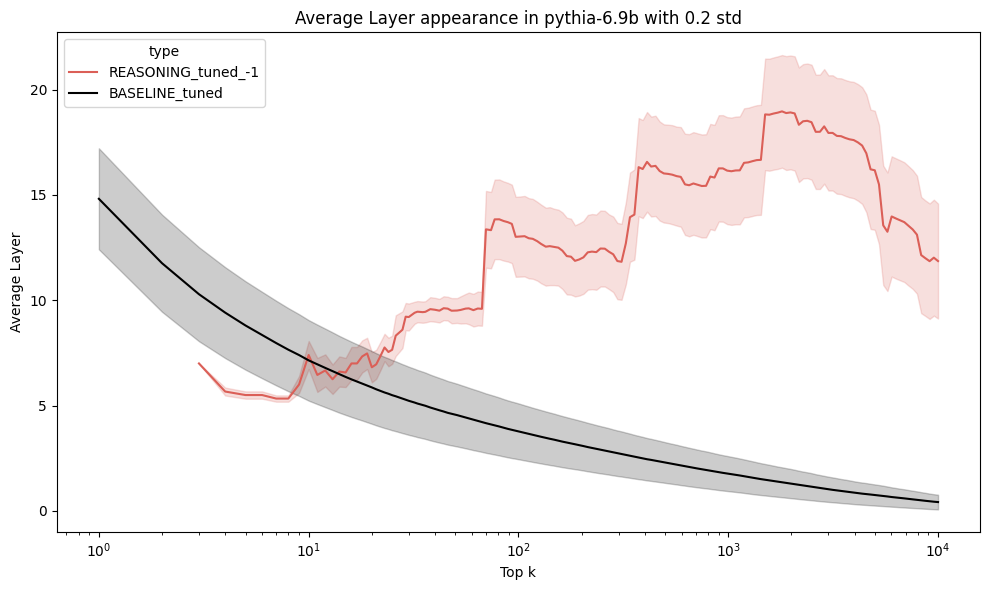

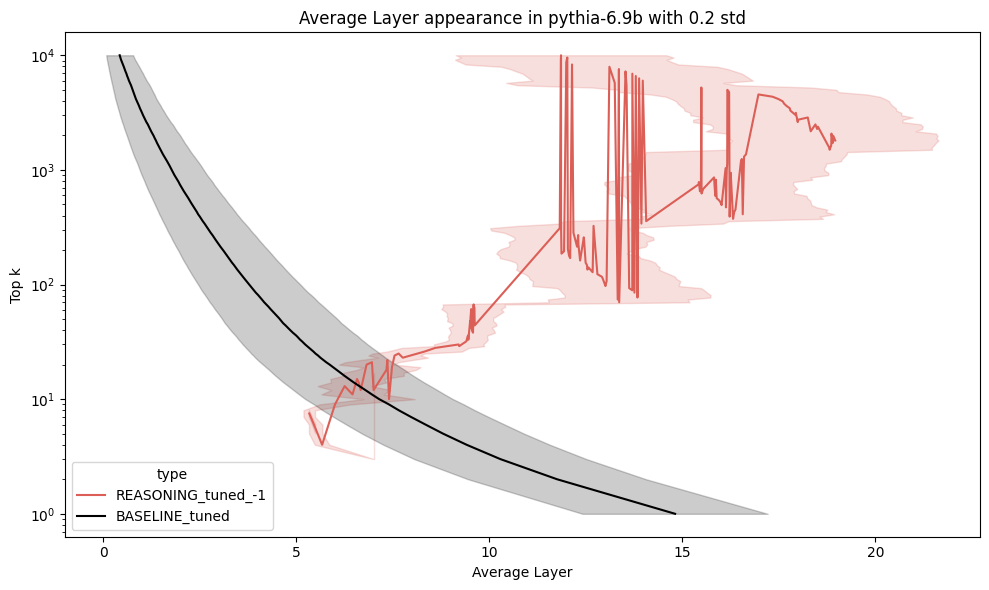

In [12]:
std = 0.2

# Plot 1: Normal axes
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='k', y='average layer', hue='type', style='type',
             palette={key: value[0] for key, value in colors.items()},
             dashes={key: value[1] for key, value in colors.items()})
for type_label in colors.keys():
    sub_df = plot_df[plot_df['type'] == type_label]
    x = sub_df['k'].to_numpy()
    y1 = (sub_df['average layer'] - std * sub_df['std layer']).to_numpy()
    y2 = (sub_df['average layer'] + std * sub_df['std layer']).to_numpy()
    plt.fill_between(x, y1, y2, alpha=0.2, color=colors[type_label][0])
plt.xscale('log')
plt.xlabel('Top k')
plt.ylabel('Average Layer')
plt.title(f'Average Layer appearance in {model} with {std} std')
plt.tight_layout()
plt.savefig(f'out/Top_k_vs_Average_Layer/{model}_{dset_type}_Top_k_vs_Average_Layer_.png')

# Plot 2: Interchanged axes
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='average layer', y='k', hue='type', style='type',
             palette={key: value[0] for key, value in colors.items()},
             dashes={key: value[1] for key, value in colors.items()})
for type_label in colors.keys():
    sub_df = plot_df[plot_df['type'] == type_label]
    y = sub_df['k'].to_numpy()
    x1 = (sub_df['average layer'] - std * sub_df['std layer']).to_numpy()
    x2 = (sub_df['average layer'] + std * sub_df['std layer']).to_numpy()
    plt.fill_betweenx(y, x1, x2, alpha=0.2, color=colors[type_label][0])
plt.yscale('log')
plt.ylabel('Top k')
plt.xlabel('Average Layer')
plt.title(f'Average Layer appearance in {model} with {std} std')
plt.tight_layout()
plt.savefig(f'out/Top_k_vs_Average_Layer/{model}_{dset_type}_interchanged_Top_k_vs_Average_Layer_.png')


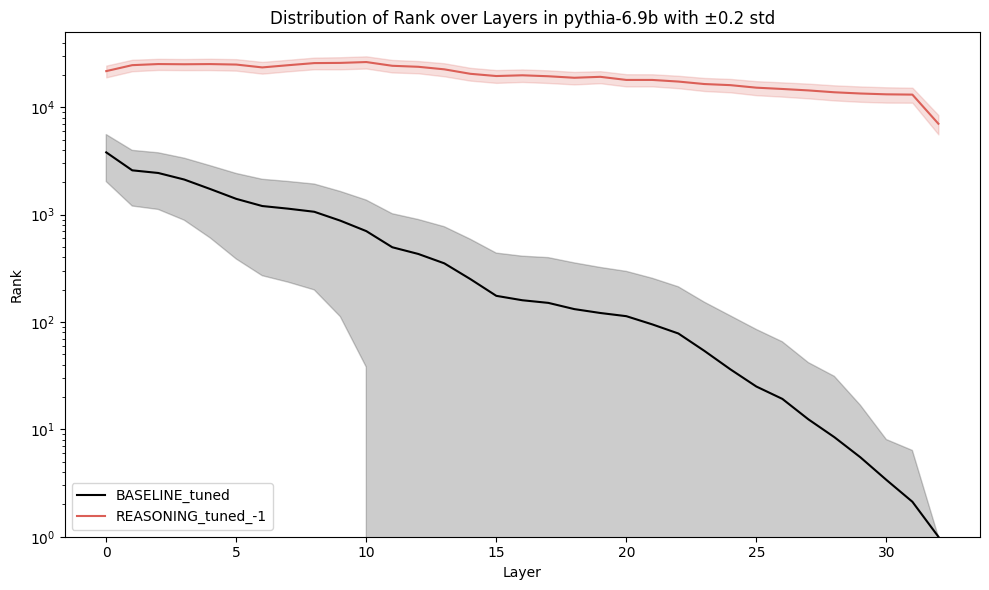

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

std = 0.2

averaged_output = output_df.groupby(['type', 'layer']).agg({
    'rank': ['mean', 'std']  
}).reset_index()

averaged_output.columns = ['type', 'layer', 'rank_mean', 'rank_std']

plt.figure(figsize=(10, 6))
types = averaged_output['type'].unique()
for type_label in types:
    subset = averaged_output[averaged_output['type'] == type_label]
    color, dashes = colors.get(type_label, ('gray', ()))
    line, = plt.plot(
        subset['layer'], 
        subset['rank_mean'], 
        label=type_label, 
        color=color,
        linestyle='-'  
    )
    if len(dashes) > 0:  
        line.set_dashes(dashes)
    lower_bound = np.maximum(subset['rank_mean'] - std * subset['rank_std'], 0)
    upper_bound = subset['rank_mean'] + std * subset['rank_std']
    plt.fill_between(
        subset['layer'], 
        lower_bound, 
        upper_bound, 
        alpha=0.2, 
        color=color
    )

plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Layer')
plt.ylabel('Rank')
plt.ylim(1, None)
plt.title(f'Distribution of Rank over Layers in {model} with ±{std} std')
plt.legend()
plt.tight_layout()
plt.savefig(f'out/Layer_vs_Rank/{model}_Layer_vs_Rank.png')
plt.show()


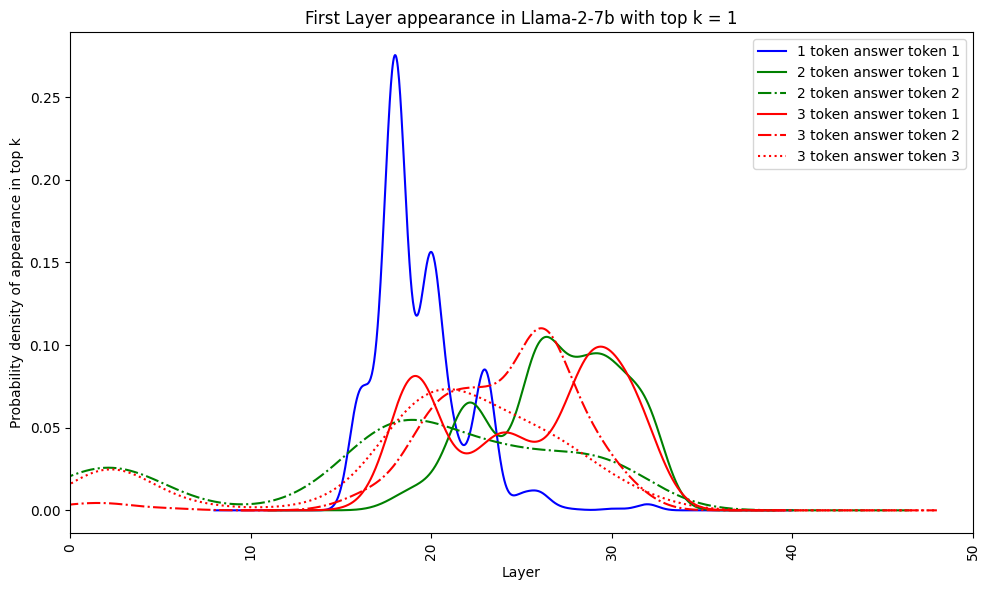

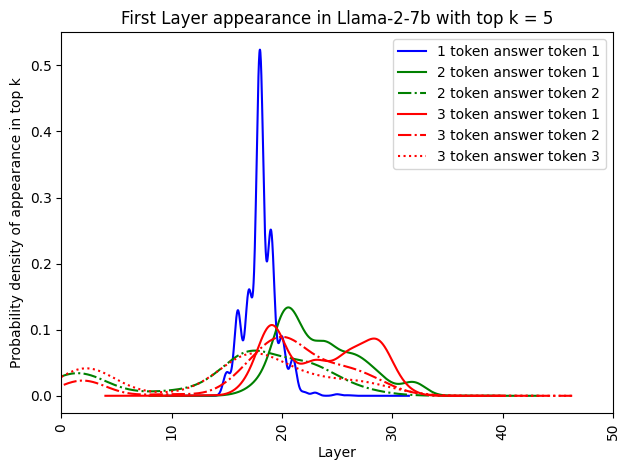

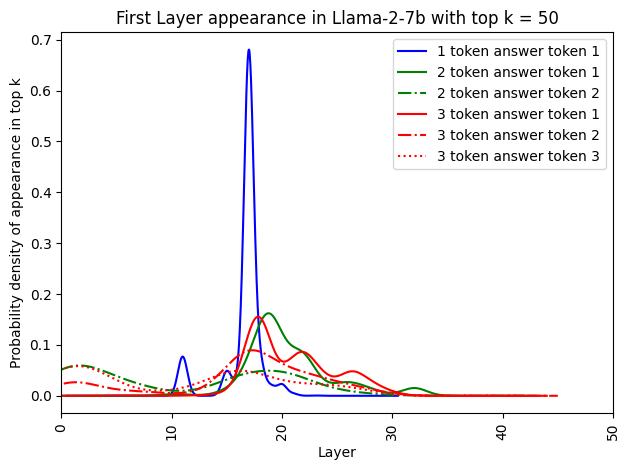

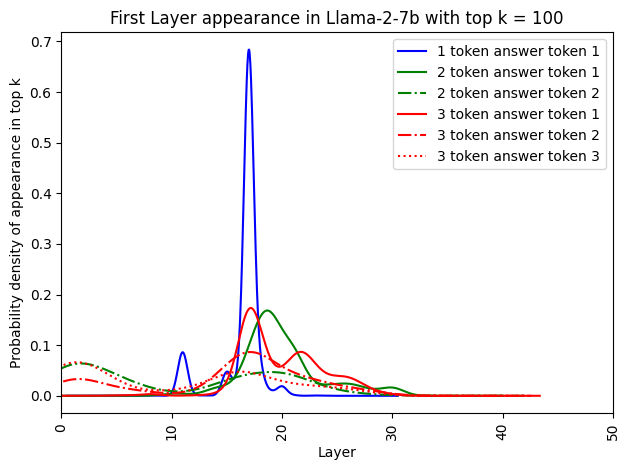

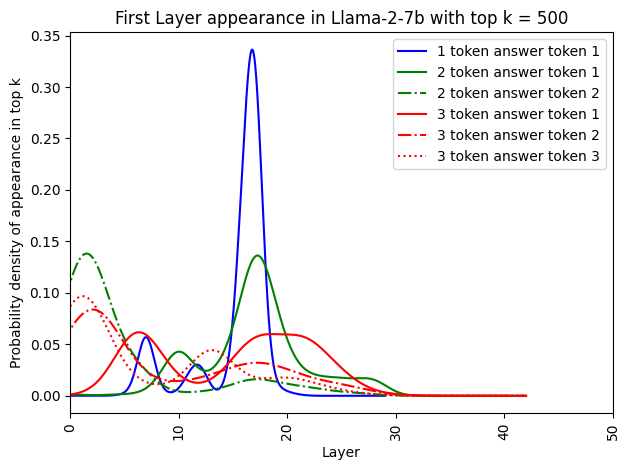

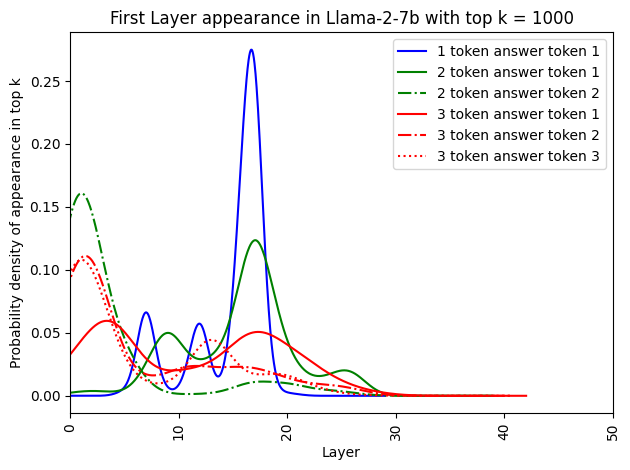

In [14]:
plt.figure(figsize=(10, 6))

ax = plt.gca()

colors = {
    '1 token answer token 1': ('blue', '-'),
    '2 token answer token 1': ('green', '-'),
    '2 token answer token 2':  ('green', '-.'),
    '3 token answer token 1':  ('red', '-'),
    '3 token answer token 2': ('red', '-.'),
    '3 token answer token 3':  ('red', ':')
}

for k in [1, 5, 50, 100, 500, 1000]:
    for type_label in colors.keys():
        color, linestyle = colors[type_label]
        
        df = output_df[output_df['type'] == type_label]
        df = df[df['rank'] <= k]
        df = df.groupby('prompt index').first()['layer']

        df.plot.kde(label=f'{type_label}', color=color, linestyle=linestyle)

    plt.xlabel('Layer')
    plt.ylabel('Probability density of appearance in top k')
    plt.title(f'First Layer appearance in {model} with top {k = }')
    plt.xticks(rotation=90)
    plt.xlim(0, 50)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [59]:
averaged_output = output_df.groupby(['type', 'layer']).agg({
    'probability': 'mean',
    'rank': 'mean', 
    'confidence': 'mean', 
    'angle_diff' : 'mean',
    'norm_diff' : 'mean'
})

averaged_output = averaged_output.sort_index()

averaged_output = averaged_output.reset_index(level = ['type'])
averaged_output.value_counts('type')

type
1 token answer token 1    49
2 token answer token 1    49
2 token answer token 2    49
3 token answer token 1    49
3 token answer token 2    49
3 token answer token 3    49
Name: count, dtype: int64

In [ ]:
plt.figure(figsize=(10, 6))
for type_label in ['FACT', 'DET', 'NOUN', 'VERB', 'ADJ', 'REASONING']: 
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df.index, df['norm_diff'], marker='o', label = type_label)
plt.xlabel('Layer')
plt.ylabel('Norm difference in consecutive layers')
plt.title('Average Norm by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
# plt.savefig(f'out/graphs/{model}_average_norm.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for type_label in ['FACT', 'DET', 'NOUN', 'VERB', 'ADJ', 'REASONING']: 
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df.index, df['angle_diff'], marker='o', label = type_label)
plt.xlabel('Layer')
plt.ylabel('Angle difference in consecutive layers')
plt.title('Average Angle by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig(f'out/graphs/{model}_average_angle.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for type_label in ['FACT', 'DET', 'NOUN', 'VERB', 'ADJ', 'REASONING']: 
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df.index, df['rank'], marker='o', label = type_label)
plt.xlabel('Layer')
plt.ylabel('Rank of correct token')
plt.title('Average Rank by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig(f'out/graphs/{model}_average_rank.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for type_label in ['FACT', 'DET', 'NOUN', 'VERB', 'ADJ', 'REASONING']: 
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df.index, df['probability'], marker='o', label = type_label)
    # df['probability_change'] = df['probability'].diff()
    # plt.plot(df.index, df['probability_change'], marker='o', label = f'{type_label} change')
plt.xlabel('Layer')
plt.ylabel('Probability of correct token')
plt.title('Average Probability by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig(f'out/graphs/{model}_average_probability.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for type_label in ['FACT', 'DET', 'NOUN', 'VERB', 'ADJ', 'REASONING']:
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df.index, df['confidence'], marker='o', label = type_label)
plt.xlabel('Layer')
plt.ylabel('Confidence')
plt.title('Average Confidence by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig(f'out/graphs/{model}_average_confidence.png')
plt.show()